In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
from pycocotools.coco import COCO
import numpy as np
import matplotlib.pyplot as plt
import pylab
pylab.rcParams['figure.figsize'] = (10.0, 8.0)
from scipy.misc import imread
import matplotlib.patches as patches
from torch.utils.data import DataLoader
from torch.optim import SGD, Adam
import cv2
from pycrayon import CrayonClient
from torch.utils.data import DataLoader
from faster_rcnn.network import  clip_gradient
import torch

def collate_fn(batch):
    return batch

In [3]:
import os
import torchvision.transforms as transforms
from faster_rcnn.utils.dataset import CocoData
from faster_rcnn.utils.data_generator import CocoGenerator
from faster_rcnn.utils.data_generator import Enqueuer

dataDir = './data/mscoco'
dataType = 'train2014'
annFile='%s/annotations/instances_%s.json'%(dataDir,dataType)
# pre_proposal_folder = './data/mscoco/coco_proposals/MCG/'

images_dir = os.path.join(dataDir,'images', dataType)
cap = CocoData(root = images_dir,
                        annFile = annFile,
#                         pre_proposal_folder=pre_proposal_folder,
                        transform=transforms.ToTensor())



data_gen = CocoGenerator(data=cap)
queue = Enqueuer(generator=data_gen)
queue.start(max_queue_size=10, workers=2)
t = queue.get()


/data
/data/data/mscoco
loading annotations into memory...
Done (t=10.56s)
creating index...
index created!


In [4]:
from faster_rcnn.faster_rcnn import  RPN

In [31]:
cc = CrayonClient(hostname="crayon", port=8889)
try:
    exp = cc.create_experiment("RPN4")
except: 
    cc.remove_experiment("RPN4")
    exp = cc.create_experiment("RPN4")

disp_interval = 100
log_interval = 10

In [6]:
net = RPN()
net.cuda()
net.train()

RPN (
  (features): Sequential (
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU (inplace)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU (inplace)
    (4): MaxPool2d (size=(2, 2), stride=(2, 2), dilation=(1, 1))
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU (inplace)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU (inplace)
    (9): MaxPool2d (size=(2, 2), stride=(2, 2), dilation=(1, 1))
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU (inplace)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU (inplace)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU (inplace)
    (16): MaxPool2d (size=(2, 2), stride=(2, 2), dilation=(1, 1))
    (17): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), pa

In [36]:
param = filter(lambda x: x.requires_grad, net.parameters())

In [34]:
for param in net.parameters():
    param.requires_grad = True
            
            

In [37]:
optimizer = Adam(param, lr=1e-5)

In [38]:
def train(data_gen, optimizer, model, epoch):
    model.train()
    train_loss = 0
    losses = []
    for step in range(1, epoch):
        blobs = data_gen.next()
#         blobs =  cap[13499]

        if blobs is None:
            continue
        if step > epoch:
            break
        im_data = blobs['data']
        im_info = blobs['im_info']
        gt_boxes = np.hstack([ blobs['boxes'] , blobs['gt_classes'][:, np.newaxis]])
        gt_ishard = blobs['gt_ishard']
        dontcare_areas = blobs['dontcare_areas']
        output = model(im_data, im_info, gt_boxes)
        loss = model.loss
        train_loss += loss.data[0]
        optimizer.zero_grad()
        loss.backward()
        clip_gradient(model, 10.)
        optimizer.step()
        loss_value = loss.data.cpu().float()
        losses.append(loss_value)
        
        
        exp.add_scalar_value('current_loss', loss.data[0], step=step)

        if step % disp_interval == 0:

            log_text = 'step %d, image: %s, loss: %.4f' % (
                step, blobs['im_name'], train_loss /(step))
            print(log_text)

            re_cnt = True

        if step % log_interval == 0:
            exp.add_scalar_value('loss', loss.data[0], step=step)
            

In [39]:
train(t, optimizer, net, 80000)

step 100, image: COCO_train2014_000000450974.jpg, loss: 0.1910
step 200, image: COCO_train2014_000000057859.jpg, loss: 0.2096
step 300, image: COCO_train2014_000000057940.jpg, loss: 0.2016
step 400, image: COCO_train2014_000000058008.jpg, loss: 0.2038
step 500, image: COCO_train2014_000000058103.jpg, loss: 0.2144
step 600, image: COCO_train2014_000000189257.jpg, loss: 0.2175
step 700, image: COCO_train2014_000000320399.jpg, loss: 0.2179
step 800, image: COCO_train2014_000000451554.jpg, loss: 0.2185
step 900, image: COCO_train2014_000000058443.jpg, loss: 0.2186
step 1000, image: COCO_train2014_000000228211.jpg, loss: 0.2187
step 1100, image: COCO_train2014_000000451834.jpg, loss: 0.2209
step 1200, image: COCO_train2014_000000320858.jpg, loss: 0.2206
step 1300, image: COCO_train2014_000000452011.jpg, loss: 0.2212
step 1400, image: COCO_train2014_000000058864.jpg, loss: 0.2224
step 1500, image: COCO_train2014_000000031671.jpg, loss: 0.2228
step 1600, image: COCO_train2014_000000452250.jpg

KeyboardInterrupt: 

In [32]:
torch.save(net.state_dict(), 'rpn3.pkl')

In [ ]:
net.load_state_dict(torch.load('./rpn.pkl'))


In [40]:
blobs =  cap[13499]
im_data = blobs['data']
im_info = blobs['im_info']
gt_boxes = np.hstack([ blobs['boxes'] , blobs['gt_classes'][:, np.newaxis]])

print blobs['boxes'] / im_info[0][2]
print blobs['image_info']
origin_gt_box =  blobs['boxes'] / im_info[0][2]

[[ 112.  203.  148.  344.]
 [ 255.  198.  354.  311.]
 [ 318.  194.  457.  316.]]
{u'license': 1, u'file_name': u'COCO_train2014_000000309241.jpg', u'coco_url': u'http://mscoco.org/images/309241', u'height': 480, u'width': 640, u'date_captured': u'2013-11-16 12:01:50', u'flickr_url': u'http://farm2.staticflickr.com/1241/992106560_15b6dd2b92_z.jpg', u'id': 309241}


In [41]:
# net.load_state_dict(torch.load('./rpn.pkl'))

net.eval()
_, result = net(im_data, im_info)

In [42]:
box_data =  result.data.cpu().numpy()
features =  _.data.cpu().numpy()
print features.shape
print box_data.shape

(1, 512, 37, 50)
(300, 5)


In [43]:
_allowed_border = 0
all_anchors = box_data[:,1:]
inds_inside = np.where(
    (all_anchors[:, 0] >= -_allowed_border) &
    (all_anchors[:, 1] >= -_allowed_border) &
    (all_anchors[:, 2] < im_info[0][1] + _allowed_border) &  # width
    (all_anchors[:, 3] < im_info[0][0] + _allowed_border)  # height
)[0]

print inds_inside

[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179
 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197
 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215
 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233
 234 235 236 237 238 239 240 241 242 243 244 245 24

In [44]:
box_data = box_data[inds_inside]

In [45]:
from faster_rcnn.utils.cython_bbox import bbox_overlaps

overlaps = bbox_overlaps(
    np.ascontiguousarray(box_data[:,1:], dtype=np.float),
    np.ascontiguousarray(origin_gt_box, dtype=np.float))

argmax_overlaps = overlaps.argmax(axis=1)  # (A)
max_overlaps = overlaps[np.arange(len(inds_inside)), argmax_overlaps]

print np.argsort(overlaps, axis=0)

[[  0 107 127]
 [169 117 129]
 [170 269 285]
 [171 268 134]
 [172 120 136]
 [173 121 137]
 [174 266 284]
 [176 123 148]
 [179 219 280]
 [180 263 150]
 [181 261 151]
 [182 200 152]
 [184 129 153]
 [185 255 154]
 [187 254 155]
 [188 133 156]
 [190 134 157]
 [193 135 159]
 [194 136 254]
 [195 137 121]
 [196 116 120]
 [198 253 117]
 [199 115  89]
 [200 113  93]
 [202  93  95]
 [203 188  96]
 [204  95  98]
 [205 274  99]
 [168 203 100]
 [167  98 102]
 [166  99 164]
 [165 100 103]
 [129 101 107]
 [131 102 286]
 [133 103 109]
 [134 105 111]
 [135 106 112]
 [136 214 114]
 [137 218 115]
 [138 109 116]
 [139 270 106]
 [140 111  88]
 [141 112 167]
 [142 114 170]
 [143  92 218]
 [206 139 219]
 [145 251 222]
 [298 196 223]
 [150 237 227]
 [151 170 228]
 [153 195 266]
 [154 172 236]
 [155 174 263]
 [156 236 239]
 [157 176 243]
 [158 224 246]
 [159 228 247]
 [160 179 261]
 [161 227 251]
 [162 181 252]
 [148 182 253]
 [128 192 270]
 [207 225 212]
 [211 185 209]
 [258 226 208]
 [259 187 275]
 [260 167 

In [46]:
sorted_overlap = np.argsort(overlaps, axis=0)
best_overlap_boxes =  sorted_overlap[-3:].flatten()
gt_argmax_overlaps = overlaps.argmax(axis=0)  # G
gt_max_overlaps = overlaps[gt_argmax_overlaps,
                           np.arange(overlaps.shape[1])]
print gt_max_overlaps
print gt_argmax_overlaps

[ 0.09262027  0.1320014   0.38560228]
[252 193 248]


In [ ]:
np.argmax(overlaps, axis=0)

In [ ]:
np.max(overlaps, axis=0)

In [ ]:
labels = np.empty((len(inds_inside),), dtype=np.float32)
labels.fill(-1)

labels[gt_argmax_overlaps] = 1
# fg label: above threshold IOU

labels[max_overlaps < 0.3] = 0
labels[max_overlaps >= 0.7] = 1
labels[max_overlaps < 0.3] = 0


unique, counts = np.unique(labels, return_counts=True)
print 'label count: ', dict(zip(unique, counts))

In [ ]:
print gt_boxes
print argmax_overlaps
gt_boxes[argmax_overlaps, :]


In [ ]:
from faster_rcnn.rpn_msr.anchor_target_layer import _compute_targets
bbox_targets = _compute_targets(box_data[:,1:], gt_boxes[argmax_overlaps, :])

print bbox_targets

In [ ]:
bbox_inside_weights = np.zeros((len(inds_inside), 4), dtype=np.float32)
bbox_inside_weights[labels == 1, :] = np.array((1. ,1. ,1. , 1.))

bbox_outside_weights = np.zeros((len(inds_inside), 4), dtype=np.float32)

num_examples = np.sum(labels >= 0) + 1
positive_weights = np.ones((1, 4)) * 1.0 / num_examples
negative_weights = np.ones((1, 4)) * 1.0 / num_examples

bbox_outside_weights[labels == 1, :] = positive_weights
bbox_outside_weights[labels == 0, :] = negative_weights
print bbox_inside_weights
print bbox_outside_weights

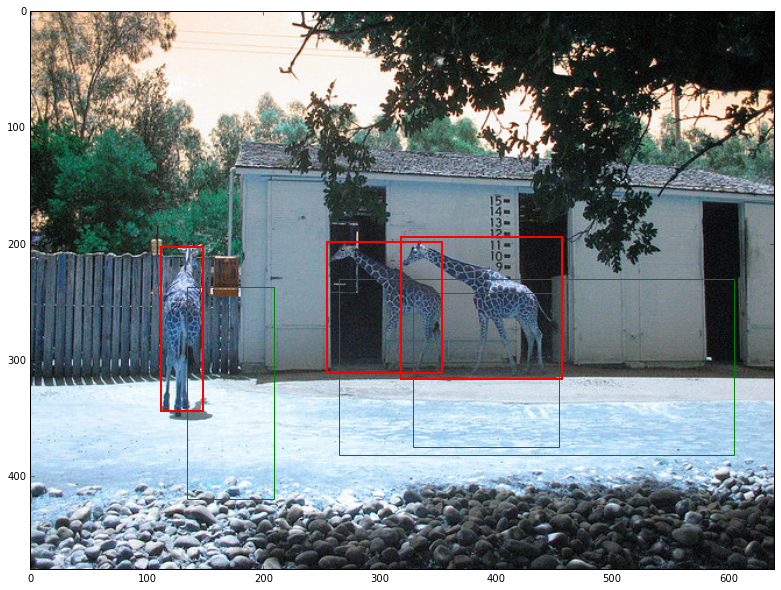

In [47]:
fig,ax = plt.subplots(1, figsize=(20, 10))
base_path = './data/mscoco/images/train2014/'
img_path = os.path.join(base_path, blobs['im_name'])
# Display the image
im_data = cv2.imread(img_path)

ax.imshow(im_data)
# Create a Rectangle patch
for i, box in enumerate(box_data[gt_argmax_overlaps]):
    box = box[1:]
    rect = patches.Rectangle((box[0], box[1]), box[2] - box[0], box[3] - box[1] ,linewidth=1,edgecolor='g',facecolor='none')
    # Add the patch to the Axes
    ax.add_patch(rect)
    
for i, box in enumerate(origin_gt_box):
    rect = patches.Rectangle((box[0], box[1]), box[2] - box[0], box[3] - box[1]  ,linewidth=2,edgecolor='r',facecolor='none')
    # Add the patch to the Axes
    ax.add_patch(rect)
    
plt.show()

# debug max overlap